# Recommendation by Character images

#### ToDo

- [x] Preparations
    - [x] data retrieval
    - [x] convert images to black and white
    - [x] set transformations (`ToTensor()`, `RandomCrop()`)
    - [x] create Dataset
    - [x] create Dataloader
- [ ] Representation learning: try with few images
    - [x] define encoder
    - [x] define decoder
    - [x] training codes 
    - [x] training loss visualization
    - [x] validation codes
    - [x] wrap training and validation codes into class
    - [ ] increase trial data size (100 to 500?)
    - [ ] create embedding
    - [ ] try saving the best encoder model, decoder model, and embedding into files
- [ ] Similarity calculation
    - [ ] convert character-based representation to title-based representation (sum for each title?)
    - [ ] NN function
    - [ ] KD-tree index if inefficient
- [ ] Recommendation
    - [ ] recommender function
    - [ ] check if it makes sense
- [ ] Full data learning ~ recommendation
    - [ ] train with larger data
    - [ ] create and save representation data
- [ ] Refactoring
    - [ ] none

#### Other
- [ ] xxxxx
- [ ] xxxxx
- [ ] xxxxx

#### Notes
1. Make training data stratified (certain proportion for each author)
2. Don’t use RGB, but black&white (single scalar value to represent 1 pixel)
3. Padding needs to be flexible
4. not sure about augmentation, but random clipping might work


In [1]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm

# images
# import cv2
from PIL import Image
import matplotlib.pyplot as plt

# pytorch
import torch
from torch import optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split

---
## Data retrieval
---

In [2]:
# # 20p -> 100 titles -> 2111 character images
# # 200p -> 6231 titles -> 39939 images

# df_charas = pd.read_csv("../assets/characters_200p.csv")
# display(df_charas.head())
# print(len(df_charas["title_id"].unique()))
# print(len(df_charas["character_id"].unique()))

In [3]:
# # Reduce the data down to first 500 titles
# first_500_titles = df_charas["title_id"].unique()[:500]
# df_charas_reduced = df_charas[df_charas["title_id"].isin(first_500_titles)]
# print(len(df_charas_reduced))
# df_charas_reduced = df_charas_reduced.drop_duplicates(subset="character_image_url")
# print(len(df_charas_reduced))
# print(len(df_charas_reduced["title_id"].unique()))
# print(len(first_500_titles))
# print(len(df_charas_reduced["character_id"].unique()))
# print(len(df_charas_reduced["character_image_url"].unique()))

# # save
# df_charas_reduced.to_csv("../assets/characters_498_titles", index=False)

---
## Image conversion: from RGB to grayscale
---

In [4]:
# get one image
img = Image.open("../assets/character_images/character_images/10138.png").convert("L")
print(img.format, img.size, img.mode)
img.save("../assets/character_images/character_images_grayscale/10138.png")

None (230, 345) L


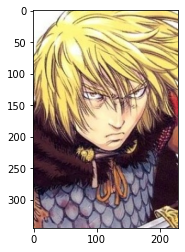

In [5]:
img = Image.open("../assets/character_images/character_images/10138.png")
plt.imshow(np.array(img))

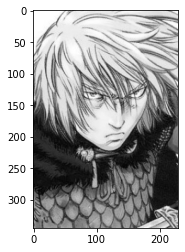

In [6]:
# Confirm grayscale conversion succeeds
img = Image.open("../assets/character_images/character_images_grayscale/10138.png")
plt.imshow(np.array(img), cmap="gray")

In [7]:
# # convert all images to grayscale
# img_list = os.listdir("../assets/character_images/character_images/")
# for img in tqdm(img_list):
#     try:
#         grey_img = Image.open("../assets/character_images/character_images/"+img).convert("L")
#         grey_img.save("../assets/character_images/character_images_grayscale/"+img)
#     except:
#         print("error at: ", img)

In [8]:
# check if all images have been converted
print(len(os.listdir("../assets/character_images/character_images/")))
print(len(os.listdir("../assets/character_images/character_images_grayscale/")))

7798
7798


---
## Check image sizes
---

In [9]:
# Research possible size patterns first
img_list = os.listdir("../assets/character_images/character_images/")
size_patterns = []
for img in img_list:
    try:
        grey_img = np.array(Image.open("../assets/character_images/character_images_grayscale/"+img))
        size_patterns.append(grey_img.shape) # each shape is (h,w)
        # checking the id of small and large images
        if (grey_img.shape[0] < 80) or (grey_img.shape[0] > 450):
            print(img)
        elif (grey_img.shape[1] < 80):
            print(img)
    except:
        pass

262137.png
183076.png
133532.png
131808.png
183075.png
82573.png
8778.png
120852.png


In [10]:
# Find the max size: each tuple is (height, width)
max_height_img = sorted(size_patterns, key=lambda x: x[0], reverse=True)[0]
max_width_img = sorted(size_patterns, key=lambda x: x[1], reverse=True)[0]
print("max height and max width images: ", max_height_img, max_width_img)

# Find the min size
min_height_img = sorted(size_patterns, key=lambda x: x[0], reverse=False)[0]
min_width_img = sorted(size_patterns, key=lambda x: x[1], reverse=False)[0]
print("min height and min width images: ", min_height_img, min_width_img)

# height can vary from 72 to 491
# width can vary from 78 to 230

# examples of small/large images 
# 262137.png # big (450, 230 ish)
# 183076.png
# 133532.png
# 131808.png
# 183075.png
# 82573.png # (72, 140)
# 8778.png # (97, 78)
# 120852.png

# 
display(pd.Series(size_patterns).value_counts())

max height and max width images:  (491, 230) (326, 230)
min height and min width images:  (72, 140) (97, 78)


(345, 230)    3251
(358, 230)    1005
(350, 225)     943
(360, 230)     297
(344, 230)     221
              ... 
(301, 230)       1
(81, 121)        1
(450, 230)       1
(280, 181)       1
(285, 208)       1
Length: 500, dtype: int64

---
## Image transformation
---

shape before transformation:  (487, 230)
shape after transformation:  torch.Size([1, 200, 200])


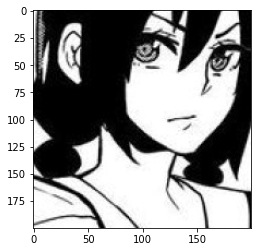

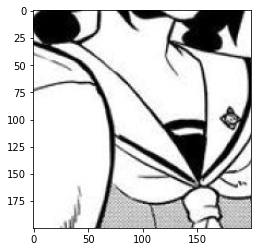

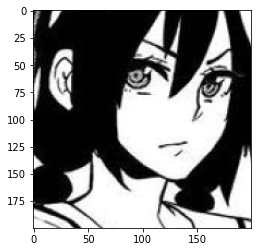

In [11]:
# transform: check cropping process
try_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.RandomCrop(200, pad_if_needed=True)
                                  ])

img = Image.open("../assets/character_images/character_images_grayscale/183076.png")

# check: tensor conversion and addition of channel dimension
img_before = np.array(img)
img_after = try_transform(img)
print("shape before transformation: ", img_before.shape) # [h,w]
print("shape after transformation: ", img_after.size()) # [c,h,w]

# check: if small/large images are cropped ok (padded if img is small)
imgs_after = [try_transform(img) for _ in range(3)]
back_transform = transforms.Compose([transforms.ToPILImage()])
for img in imgs_after:
    pil_img = back_transform(img)
    plt.imshow(np.array(pil_img), cmap="gray")
    plt.show()

---
## Dataset and Dataloader
---

In [12]:
# # quick preparation of trial data
# img_list = os.listdir("../assets/character_images/character_images/")
# for img in tqdm(img_list[:100]):
#     try:
#         grey_img = Image.open("../assets/character_images/character_images/"+img).convert("L")
#         grey_img.save("../assets/character_images/character_images_grayscale_test/"+img)
#     except:
#         print("error at: ", img)

In [13]:
class MangaDataset(Dataset):

    def __init__(self, target_dir, transform_steps=None):
        self.target_dir = target_dir
        self.transform_steps = transform_steps
        self.target_imgs = os.listdir(target_dir)

    def __len__(self):
        return len(self.target_imgs)

    def __getitem__(self, idx):
        img_path = os.path.join(self.target_dir, self.target_imgs[idx])
        img = Image.open(img_path)

        if self.transform_steps:
            tensor_img = self.transform_steps(img)

        return tensor_img, tensor_img # first is input to the model, second is input for reconstruction
    

In [14]:
# Define transformations and initialize Dataset
transform_steps = transforms.Compose([transforms.ToTensor(),
                                      transforms.RandomCrop(200, pad_if_needed=True)
                                     ])
manga_dataset = MangaDataset("../assets/character_images/character_images_grayscale_test", transform_steps)

In [15]:
# Set DataLoader

# Split train and data
train_size = int(manga_dataset.__len__() * 0.75)
val_size = int(manga_dataset.__len__() - train_size)
train_dataset, val_dataset = random_split(manga_dataset, [train_size, val_size]) 

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# All dataloader
all_data_loader = DataLoader(manga_dataset, batch_size=32)

2
<class 'tuple'>
torch.Size([1, 200, 200])
input batch shape: torch.Size([32, 1, 200, 200])
output batch shape: torch.Size([32, 1, 200, 200])


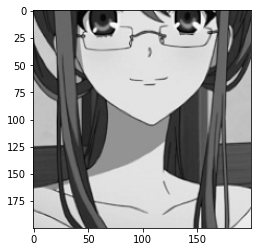

In [16]:
# Check Dataset
img_ex = train_dataset.__getitem__(0)
print(len(img_ex))
print(type(img_ex))
print(img_ex[0].shape)

# Check DataLoader
input_tensor, output_tensor = next(iter(train_loader))
print(f"input batch shape: {input_tensor.size()}")
print(f"output batch shape: {output_tensor.size()}")
img_ex = input_tensor[0].squeeze()
plt.imshow(img_ex, cmap="gray")
plt.show()

In [17]:
# set the steps as a function
def prep_data(data_path, transform_steps, train_ratio, batch_size):
    manga_dataset = MangaDataset(data_path, transform_steps)
    train_size = int(manga_dataset.__len__() * 0.75)
    val_size = int(manga_dataset.__len__() - train_size)
    train_dataset, val_dataset = random_split(manga_dataset, [train_size, val_size]) 
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32)
    all_data_loader = DataLoader(manga_dataset, batch_size=32)
    return train_loader, val_loader, all_data_loader

---
## Autoencoder
---

In [18]:
# Encoder
class Encoder(nn.Module):

    def __init__(self):
        super().__init__()

        # note on nn.ReLU(inplace=True) -> https://discuss.pytorch.org/t/whats-the-difference-between-nn-relu-and-nn-relu-inplace-true/948/4
        self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
        self.relu1 = nn.ReLU(inplace=True)
        self.maxpool1 = nn.MaxPool2d(2)

        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.relu2 = nn.ReLU(inplace=True)
        self.maxpool2 = nn.MaxPool2d(2)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.relu3 = nn.ReLU(inplace=True)
        self.maxpool3 = nn.MaxPool2d(2)

        self.conv4 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu4 = nn.ReLU(inplace=True)
        self.maxpool4 = nn.MaxPool2d(2)

        self.conv5 = nn.Conv2d(128, 256, 3, padding=1)
        self.relu5 = nn.ReLU(inplace=True)
        self.maxpool5 = nn.MaxPool2d(2)


    def forward(self, x):
        x = self.maxpool1(self.relu1(self.conv1(x)))
        x = self.maxpool2(self.relu1(self.conv2(x)))
        x = self.maxpool3(self.relu1(self.conv3(x)))
        x = self.maxpool4(self.relu1(self.conv4(x)))
        x = self.maxpool5(self.relu1(self.conv5(x)))
        
        return x

In [19]:
# Decoder
class Decoder(nn.Module):

    def __init__(self):
        super().__init__()
        # shaping output: H_out = ((H_in - 1) * str) - (2 * pad) + (dilation * kernel-1) + output_pad + 1
        # just make output (h, w) to be 200,200

        self.deconv1 = nn.ConvTranspose2d(256, 128, 2, stride=2) # (6-1)*2-(2*0)+(1*(2-1)+0+1 = 10-0+1+1 = 12
        self.relu1 = nn.ReLU(inplace=True)

        self.deconv2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.relu2 = nn.ReLU(inplace=True)

        self.deconv3 = nn.ConvTranspose2d(64, 32, 2, stride=2, output_padding=1)
        self.relu3 = nn.ReLU(inplace=True)

        self.deconv4 = nn.ConvTranspose2d(32, 16, 2, stride=2, output_padding=1)
        self.relu4 = nn.ReLU(inplace=True)

        self.deconv5 = nn.ConvTranspose2d(16, 1, 3, stride=2, output_padding=1)
        self.relu5 = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.relu1(self.deconv1(x)) # shape = [32, 128, 12, 12] height is 12, so correct.
        x = self.relu2(self.deconv2(x))
        x = self.relu3(self.deconv3(x))
        x = self.relu4(self.deconv4(x))
        x = self.relu5(self.deconv5(x))

        return x

torch.Size([32, 1, 200, 200])
encoder output shape:  torch.Size([32, 256, 6, 6])
decoder output shape:  torch.Size([32, 1, 200, 200])


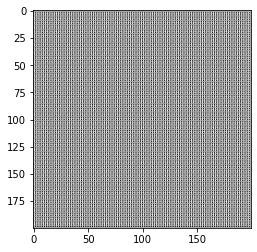

In [20]:
# test encoder
encoder = Encoder()
encoder.train()
input_tensor, output_tensor = next(iter(train_loader))
print(input_tensor.shape)
encoder_output = encoder(input_tensor)
print("encoder output shape: ", encoder_output.shape) # [batch_size, channel, h, w]

# test decoder
decoder = Decoder()
decoder.train()
decoder_output = decoder(encoder_output)
print("decoder output shape: ", decoder_output.shape) # [batch_size, channel, h, w]

# show the decoder output -> just shows patterns since it's the very first layer
img_ex = decoder_output[0].detach().numpy().squeeze()
plt.imshow(img_ex, cmap="gray")
plt.show()

---
## Training and Validation
---

In [21]:
# initialize again, set to train mode, send models to gpu
encoder = Encoder()
decoder = Decoder()
encoder.train()
decoder.train()
device = "cuda"
encoder.to(device)
decoder.to(device)

# set loss function, optimizer
criterion = nn.MSELoss()
ae_params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(ae_params, lr=0.01)

# train
losses = []

for epoch in tqdm(range(100)):
    running_loss = 0.0
    for counter, (train_img, target_img) in enumerate(train_loader, 1):
        train_img = train_img.to(device)
        target_img = target_img.to(device)

        optimizer.zero_grad()
        # forward
        enc_output = encoder(train_img)
        dec_output = decoder(enc_output)

        loss = criterion(dec_output, target_img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / counter
    losses.append(avg_loss)

100%|████████████████████████████████████████████████████████| 100/100 [00:31<00:00,  3.20it/s]


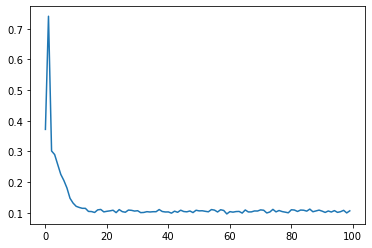

In [22]:
# quick plot of training losses
plt.plot(losses)

In [23]:
encoder.eval()
decoder.eval()

# validate
val_losses = []

for epoch in tqdm(range(100)):
    with torch.no_grad():
        running_loss = 0.0
        for counter, (train_img, target_img) in enumerate(val_loader, 1):
            train_img = train_img.to(device)
            target_img = target_img.to(device)

            # forward
            enc_output = encoder(train_img)
            dec_output = decoder(enc_output)

            # calculate loss
            loss = criterion(dec_output, target_img)
            running_loss += loss.item()
        avg_loss = running_loss / counter
        val_losses.append(avg_loss)

100%|████████████████████████████████████████████████████████| 100/100 [00:06<00:00, 15.36it/s]


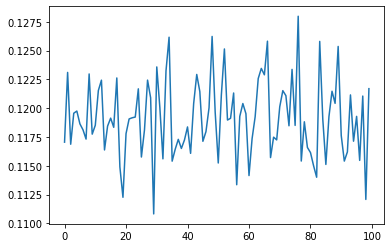

In [24]:
# quick plot of training losses
plt.plot(val_losses)

In [25]:
# Putting training and validation into methods
def train_step(encoder, decoder, train_loader, criterion, optimizer, device):
    encoder.train()
    decoder.train()

    running_loss = 0.0
    for counter, (train_img, target_img) in enumerate(train_loader, 1):
        train_img = train_img.to(device)
        target_img = target_img.to(device)

        optimizer.zero_grad()
        enc_output = encoder(train_img)
        dec_output = decoder(enc_output)

        loss = criterion(dec_output, target_img)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / counter
    return avg_loss


def val_step(encoder, decoder, val_loader, criterion, device):
    encoder.eval()
    decoder.eval()

    running_loss = 0.0
    with torch.no_grad():
        for counter, (train_img, target_img) in enumerate(val_loader, 1):
            train_img = train_img.to(device)
            target_img = target_img.to(device)

            # forward
            enc_output = encoder(train_img)
            dec_output = decoder(enc_output)

            # calculate loss
            loss = criterion(dec_output, target_img)
            running_loss += loss.item()
        avg_loss = running_loss / counter
        return avg_loss

In [30]:
# train and validate to check that the methods work

# redo the settings all again

# set data
transform_steps = transforms.Compose([transforms.ToTensor(),transforms.RandomCrop(200, pad_if_needed=True)])
train_loader, val_loader, all_data_loader = prep_data("../assets/character_images/character_images_grayscale_test", 
                                                      transform_steps=transform_steps, train_ratio=0.75, batch_size=32)

# prep model
encoder = Encoder()
decoder = Decoder()
device = "cuda"
encoder.to(device)
decoder.to(device)

# set loss function, optimizer
criterion = nn.MSELoss()
ae_params = list(encoder.parameters()) + list(decoder.parameters())
optimizer = optim.Adam(ae_params, lr=0.01)

# check that it works
EPOCHS = 50
train_losses = []
val_losses = []

for epoch in range(1, EPOCHS+1):    
    train_loss = train_step(encoder, decoder, train_loader, criterion, optimizer, device=device)
    train_losses.append(train_loss)
    print(f"Epochs = {epoch}, Training Loss : {train_loss}")

    val_loss = val_step(encoder, decoder, val_loader, criterion, device=device)
    val_losses.append(val_loss)
    print(f"Epochs = {epoch}, Validation Loss : {val_loss}")

Epochs = 1, Training Loss : 2.5325039823849997
Epochs = 1, Validation Loss : 0.40600305795669556
Epochs = 2, Training Loss : 0.41355715195337933
Epochs = 2, Validation Loss : 0.4509134888648987
Epochs = 3, Training Loss : 0.424388845761617
Epochs = 3, Validation Loss : 0.44390180706977844
Epochs = 4, Training Loss : 0.42388126254081726
Epochs = 4, Validation Loss : 0.436103492975235
Epochs = 5, Training Loss : 0.4445691208044688
Epochs = 5, Validation Loss : 0.44070565700531006
Epochs = 6, Training Loss : 0.3982117374738057
Epochs = 6, Validation Loss : 0.392161101102829
Epochs = 7, Training Loss : 0.3707759976387024
Epochs = 7, Validation Loss : 0.36337798833847046
Epochs = 8, Training Loss : 0.3273189167181651
Epochs = 8, Validation Loss : 0.35388630628585815
Epochs = 9, Training Loss : 0.2926226059595744
Epochs = 9, Validation Loss : 0.2919047772884369
Epochs = 10, Training Loss : 0.2625800520181656
Epochs = 10, Validation Loss : 0.2535010278224945
Epochs = 11, Training Loss : 0.232